In [ ]:
# This is based off of a model from Saadman Sakib. Link: https://www.kaggle.com/code/saadmansakib/human-fall-detection-using-random-forest-97-47

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import warnings
import os
import random
%matplotlib inline
random.seed(42)
plt.rcParams.update({'font.size': 25})
sns.set_theme(color_codes=True)
warnings.filterwarnings('ignore')

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

train_df = pd.read_csv("../input/smartphone-human-fall-dataset/Train.csv")
test_df = pd.read_csv('../input/smartphone-human-fall-dataset/Test.csv')

X_train = train_df.drop(['fall','label', 'Unnamed: 0'],axis=1)
y_train = train_df['fall']
X_test =  test_df.drop(['fall','label', 'Unnamed: 0'], axis=1)
y_test =  test_df['fall']

/kaggle/input/smartphone-human-fall-dataset/Train.csv
/kaggle/input/smartphone-human-fall-dataset/Test.csv


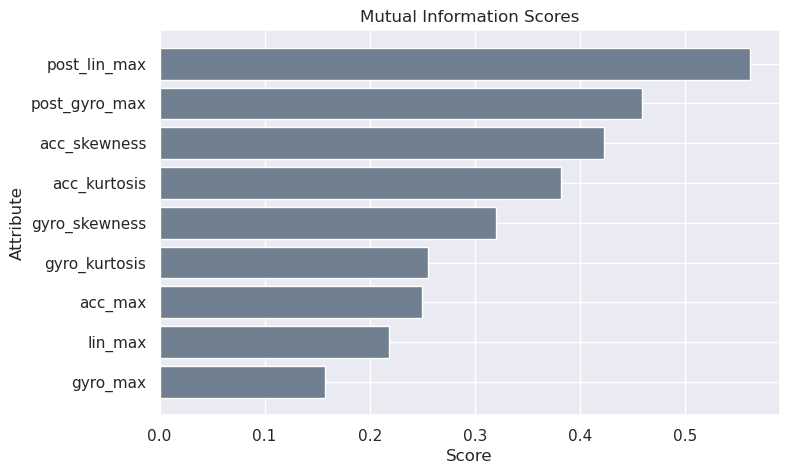

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)

def plot_utility_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y, color = 'slategrey')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plt.xlabel("Score")
plt.ylabel("Attribute")
plot_utility_scores(mi_scores)


<AxesSubplot:>

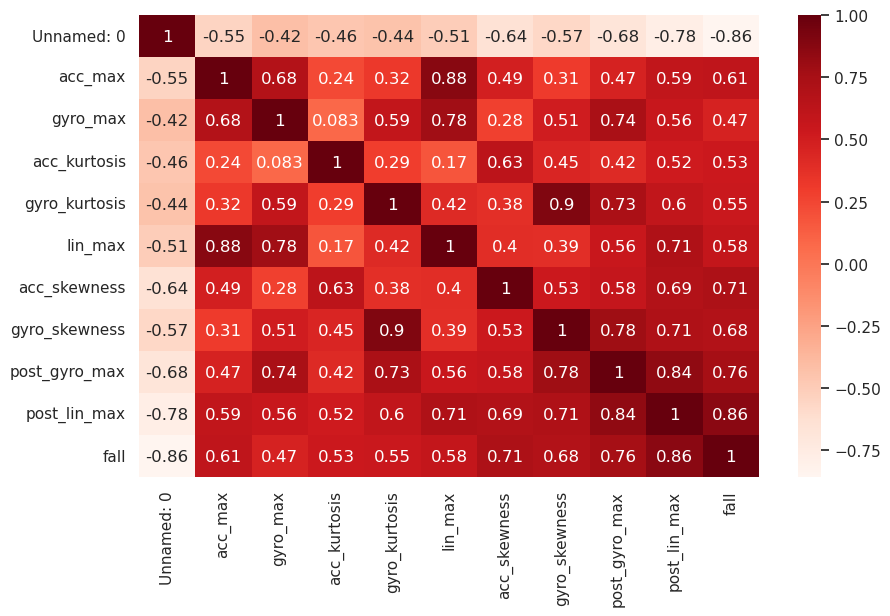

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(train_df.corr(), ax=ax,  cmap="Reds", annot=True)


In [ ]:
X_train.drop(['gyro_max'], axis=1, inplace=True)
X_test.drop(['gyro_max'], axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
n_estimators = [200,400,600,800,1000]
max_features = ['auto', 'sqrt']
max_depth = [None,10,30,50,70]
min_samples_split = [2, 5, 9, 12]
min_samples_leaf = [1, 3, 5, 7]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5,
                               random_state=42,
                               n_jobs = -1
                              )
rf_random.fit(X_train, y_train)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 10, 30, 50, 70], 'min_samples_split': [2, 5, 9, 12], 'min_samples_leaf': [1, 3, 5, 7], 'bootstrap': [True, False]}


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 30, 50, 70],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'min_samples_split': [2, 5, 9, 12],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = (((predictions==test_labels).sum())/test_labels.shape[0])*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

best_estimator = rf_random.best_estimator_
optimal_accuracy = evaluate(best_estimator, X_test, y_test)

Model Performance
Accuracy = 100.00%.
